# Load libraries 

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load Data

In [11]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# EDA

In [12]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


* Select relevant columns

In [13]:
selected_features = ["GrLivArea", "BedroomAbvGr", "FullBath", "SalePrice"]
data = train_data[selected_features]

* Check for missing values

In [14]:
missing_values = data.isnull().sum()
missing_values

GrLivArea       0
BedroomAbvGr    0
FullBath        0
SalePrice       0
dtype: int64

* Display summary statistics

In [15]:
data.describe()

,GrLivArea,BedroomAbvGr,FullBath,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000
mean,1515.463699,2.866438,1.565068,180921.195890
std,525.480383,0.815778,0.550916,79442.502883
min,334.000000,0.000000,0.000000,34900.000000
25%,1129.500000,2.000000,1.000000,129975.000000
50%,1464.000000,3.000000,2.000000,163000.000000
75%,1776.750000,3.000000,2.000000,214000.000000
max,5642.000000,8.000000,3.000000,755000.000000


* visualize the relationships between features and house prices using scatter plots and correlation heatmaps.

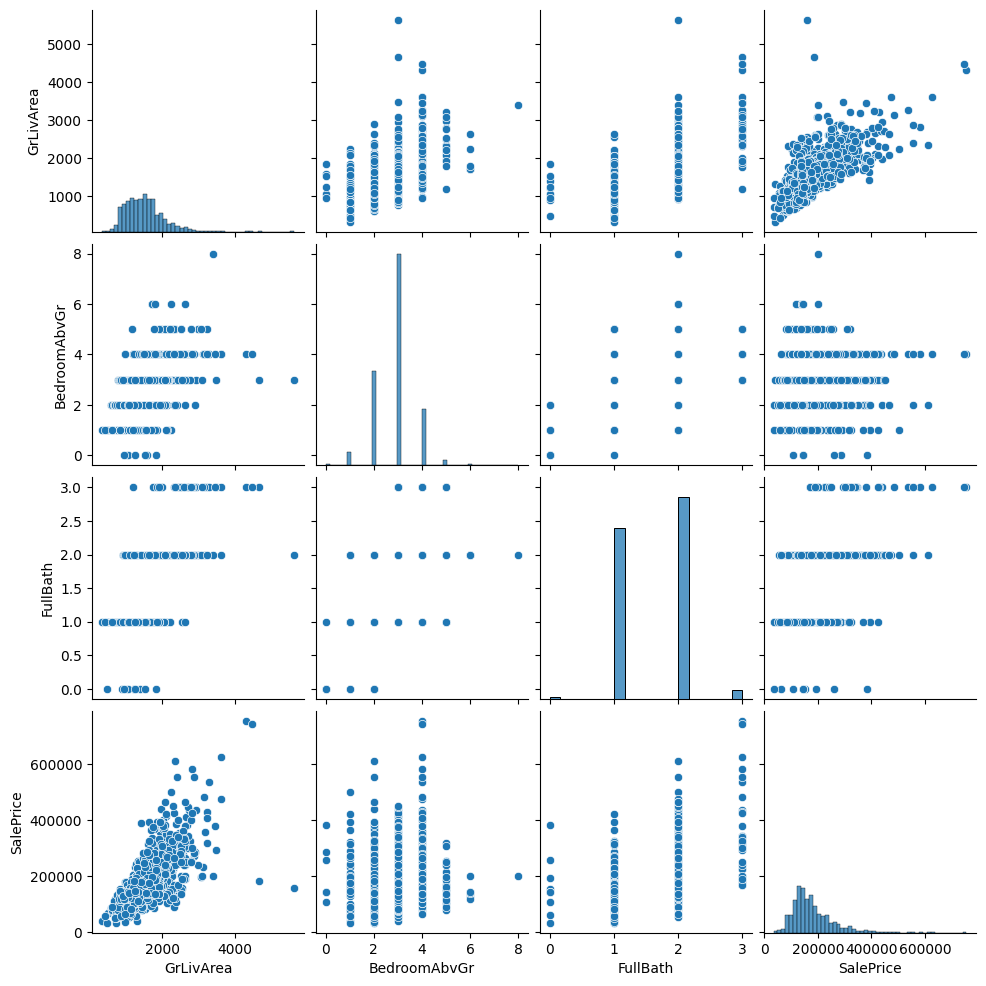

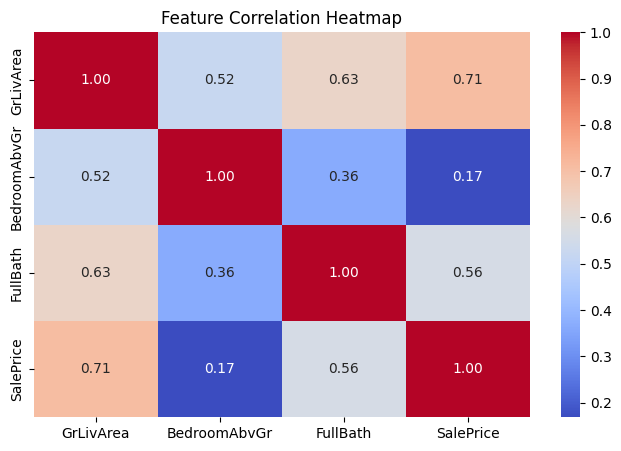

In [16]:
# Pairplot to visualize relationships
sns.pairplot(data)
plt.show()

# heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Data Preprocessing
* What We Need to Do:
- Handle Missing Values → already checked, and there are no missing values.
- Handle Outliers → identify and remove outliers in GrLivArea using the IQR method.
- Feature Scaling (Optional) → Linear regression does not require scaling, but it may help with stability.


In [17]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal to GrLivArea
data_cleaned = remove_outliers(data, "GrLivArea")

# Check new dataset size after removing outliers
data_cleaned.shape

(1429, 4)

# train the model

In [18]:
X_cleaned = data_cleaned[["GrLivArea", "BedroomAbvGr", "FullBath"]]
y_cleaned = data_cleaned["SalePrice"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

# Apply standardization (scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check the scaled data
X_train_scaled[:5]

array([[-0.78397963,  0.23757848, -0.99128245],
       [-0.0269058 ,  0.23757848,  0.86311336],
       [-0.53759465,  0.23757848, -0.99128245],
       [-0.17025705,  0.23757848, -0.99128245],
       [ 0.58233705,  1.49476461,  0.86311336]])

In [19]:
model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_scaled = model_scaled.predict(X_test_scaled)

# Evaluate the model with cleaned and scaled data
mae_scaled = mean_absolute_error(y_test, y_pred_scaled)
mse_scaled = mean_squared_error(y_test, y_pred_scaled)
rmse_scaled = np.sqrt(mse_scaled)
r2_scaled = r2_score(y_test, y_pred_scaled)

# Display evaluation metrics
mae_scaled, mse_scaled, rmse_scaled, r2_scaled

(36826.85910240441,
 2327637627.5544467,
 np.float64(48245.596975832384),
 0.5103771476008061)

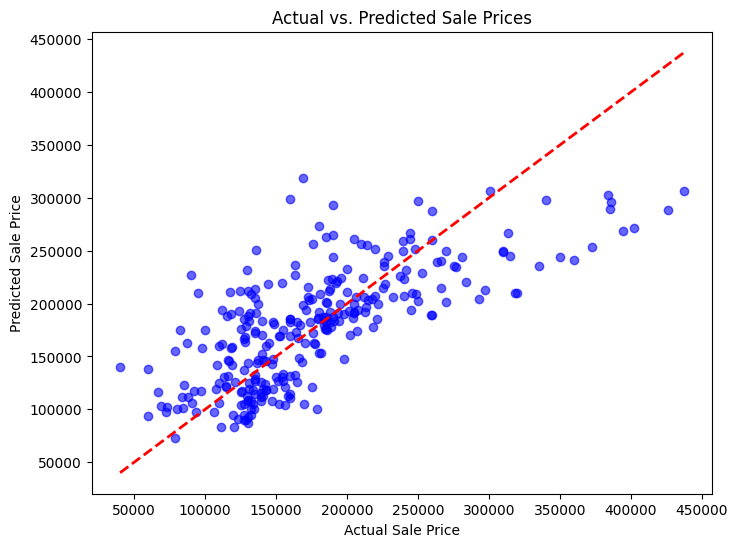

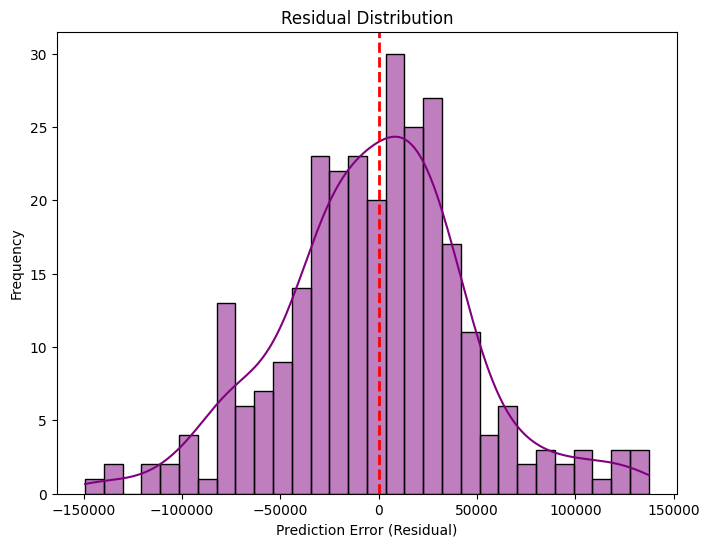

In [20]:
# Visualization of Actual vs. Predicted Prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_scaled, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', linestyle='dashed', linewidth=2)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs. Predicted Sale Prices")
plt.show()

# Residual Plot (Errors)
residuals = y_test - y_pred_scaled

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.axvline(x=0, color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

# Summary of Findings in House Price Prediction

## 1. Feature Importance
- **GrLivArea (Living Area)** has the **strongest correlation** with house price (**0.71**).
- **FullBath (Bathrooms)** has a **moderate positive effect** on price.
- **BedroomAbvGr (Bedrooms)** showed a **negative coefficient**, suggesting more bedrooms don’t always increase price.

## 2. Model Performance
- The model explains **~51% of the price variations** (**R² = 0.510**).
- The **average prediction error (MAE)** is around **$36,826**.
- The **model struggles with expensive houses**, leading to larger errors.

## 3. Error Analysis
- The **residuals (errors) are normally distributed**, but some houses are **over- or under-predicted** significantly.
- Expensive houses tend to have **larger prediction errors**, indicating **missing important features** like neighborhood, lot size, or house condition.

## 4. Key Limitations Identified
- **Only 3 features** were used, which may not be enough to fully capture house price trends.
- **Outlier removal improved error metrics**, but R² dropped, meaning **some valuable data was lost**.
- **Linear Regression assumes a straight-line relationship**, but house prices might have **non-linear trends**.

## 5. Recommendations for Improvement
- **Include more features** (e.g., LotArea, GarageArea, YearBuilt, Neighborhood).
- **Try more advanced models** like **Polynomial Regression** or **Ridge Regression** to improve performance.
- **Feature engineering** (e.g., interaction terms) can help capture complex relationships.
